In [1]:
import sys
sys.dont_write_bytecode = True
import time
import numpy as np
from matplotlib import pyplot as plt
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_resonator as resonator
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 500
%matplotlib inline

# Parameters

In [3]:
nlev_lc = 30
nlev_single = 7  # The number of single-qubit levels to show.
take_data_from_input_file = False

if not take_data_from_input_file:
    # Parameters of the first fluxonium.
    E_L1 = 0.5 # inductive energy
    E_C1 = 1.0  # charging energy
    E_J1 = 3.5  # Josephson energy
    phi_ext1 = np.pi  # external phase shift

    # Parameters of the second fluxonium.
    E_L2 = 0.5  # inductive energy
    E_C2 = 1.0  # charging energy
    E_J2 = 3.5  # Josephson energy
    phi_ext2 = np.pi  # external phase shift

    # Interaction energy between two fluxoniums.
    # E_int n_1 n_2 or E_int phi_1 phi_2.
    E_int = 0.2  # when a single value is needed
    E_int_range = np.linspace(0, 0.3, 11)  # when a range is needed
    coupling = 'charge'  # 'charge' or 'flux'
    
    # Parameters of the coupling resonators
    omega_c = 6.5 

qubit1 = fluxonium.Fluxonium(E_J = E_J1, E_C=E_C1, E_L=E_L1, phi_ext=phi_ext1, nlev = nlev_single, nlev_lc = nlev_lc)
qubit2 = fluxonium.Fluxonium(E_J = E_J2, E_C=E_C2, E_L=E_L2, phi_ext=phi_ext2, nlev = nlev_single, nlev_lc = nlev_lc)
coupl_res = resonator.Cavity(omega=omega_c, nlev=5)

print("Qubit A: %s" % (qubit1))
print("Qubit B: %s" % (qubit2))
print("Resonator: %s" % (resonator))

anchor_freq1 = qubit1.freq(0,1)
anchor_freq2 = qubit2.freq(0,1)

Qubit A: A fluxonium qubit with E_L = 0.5 GHz, E_C = 1.0 GHz, and E_J = 3.5 GHz. The external phase shift is phi_ext/pi = 1.0.
Qubit B: A fluxonium qubit with E_L = 0.5 GHz, E_C = 1.0 GHz, and E_J = 3.5 GHz. The external phase shift is phi_ext/pi = 1.0.
Resonator: <module 'Fluxonium_hamiltonians.qchard_resonator' from '/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/Fluxonium_hamiltonians/qchard_resonator.py'>


# Sweep coupling to resonator

In [4]:
#Sweep the coupling strength, JC-charge
E_int_array = np.linspace(0, 0.3, 31)
E_int_direct = 0.00
phi_ext = np.pi
qubit1.phi_ext = phi_ext
qubit2.phi_ext = phi_ext
# print (qubit1.n_ij(level1=0,level2=1))
# print (qubit2.n_ij(level1=0,level2=1))
# print (qubit1.phi_ij(level1=0,level2=1))
# print (qubit2.phi_ij(level1=0,level2=1))
energies_coupled_swE = np.zeros((qubit1.nlev * qubit2.nlev*coupl_res.nlev, len(E_int_array)))

for idx, E_int in enumerate(E_int_array):
    system = coupobj.CoupledObjects(qubit1, qubit2, coupl_res,
                                    [qubit1, qubit2, E_int_direct, coupling],
                                    [coupl_res, qubit1, E_int, 'JC-charge'],
                                    [coupl_res, qubit2, E_int, 'JC-charge'])
    energies_coupled_swE[:,idx] = system.levels()

(0.0, 0.3)

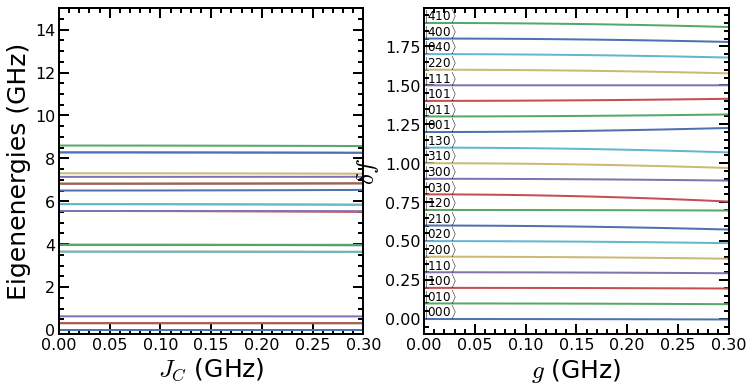

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = [12,6])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

nlev_show = 20
#Transition freqs
for idx in range(0, nlev_show):
    ax1.plot(E_int_array, energies_coupled_swE[idx, :]-energies_coupled_swE[0, :], linewidth = 2.0)
ax1.set_xlabel('$J_C$ (GHz)')
ax1.set_ylabel('Eigenenergies (GHz)')
ax1.set_xlim([E_int_array[0], E_int_array[-1]])
ax1.set_ylim([-0.2,15])

#State labeling
for idx in range(0, nlev_show):
    ax2.plot(E_int_array, 0.1 * idx+(energies_coupled_swE[idx, :]-energies_coupled_swE[idx, 0]), linewidth = 2.0)
    label = (r'$|$' + system.level_label(idx, label_format='str') + r'$\rangle$')
    ax2.text(0, 0.02 + 0.1 * idx, label, fontsize=12)
ax2.set_xlabel('$g$ (GHz)')
ax2.set_ylabel(r'$\delta f$')
ax2.set_xlim([E_int_array[0], E_int_array[-1]])

(0.0, 300.0)

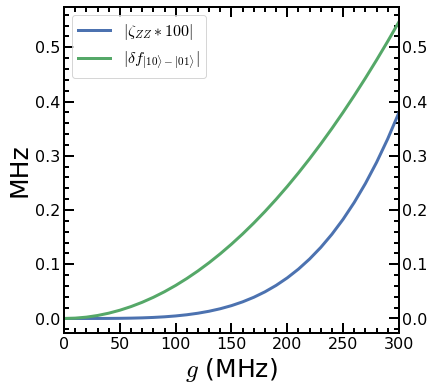

In [6]:
#Calculate ZZ rate:
plt.figure(figsize = [6,6])
zeta_ZZ = energies_coupled_swE[system.level_label('110'),:] - energies_coupled_swE[system.level_label('010'),:] \
- (energies_coupled_swE[system.level_label('100'), :] - energies_coupled_swE[system.level_label('000'), :])
freq_shift = energies_coupled_swE[system.level_label('100'), :] - energies_coupled_swE[system.level_label('010'), :]
freq_anchor = freq_shift[0]
freq_shift = freq_shift - freq_anchor
plt.plot(E_int_array*1e3, abs(zeta_ZZ)*1e5, label = r'$|\zeta_{ZZ}*100|$')
plt.plot(E_int_array*1e3, abs(freq_shift)*1e3, label = r'$|\delta f _{|10\rangle - |01\rangle}|$')

plt.legend()
plt.tick_params(left=True, right=True,labelleft=True, labelright=True)
# plt.ylabel('MHz')
plt.ylabel(r'MHz')
plt.xlabel('$g$ (MHz)')
plt.xlim([E_int_array[0]*1e3, E_int_array[-1]*1e3])


# Sweep resonator's frequency

In [82]:
## Keep coupling fixed, sweep the resonator's frequency
w_c_array = np.linspace(3,15,121)
E_int_res = 0.3
E_int_direct = 0.0
phi_ext = np.pi
qubit1.phi_ext = phi_ext
qubit2.phi_ext = phi_ext
energies_coupled_swE = np.zeros((qubit1.nlev * qubit2.nlev*coupl_res.nlev, len(w_c_array)))

for idx, w_c in enumerate(w_c_array):
    coupl_res = resonator.Cavity(omega=w_c, nlev = 5)
    system = coupobj.CoupledObjects(qubit1, qubit2, coupl_res,
                                    [qubit1, qubit2, E_int_direct, coupling],
                                    [coupl_res, qubit1, E_int_res, 'JC-charge'],
                                    [coupl_res, qubit2, E_int_res, 'JC-charge'])
    energies_coupled_swE[:,idx] = system.levels()

Text(0, 0.5, 'MHz')

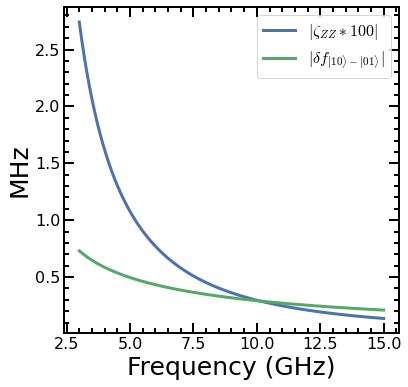

In [83]:
#Calculate ZZ rate:
plt.figure(figsize = [6,6])
zeta_ZZ = energies_coupled_swE[system.level_label('110'),:] - energies_coupled_swE[system.level_label('010'),:] \
- (energies_coupled_swE[system.level_label('100'), :] - energies_coupled_swE[system.level_label('000'), :])
freq_shift = energies_coupled_swE[system.level_label('100'), :] - energies_coupled_swE[system.level_label('010'), :]
freq_shift = freq_shift - freq_anchor
plt.plot(w_c_array, abs(zeta_ZZ)*1e5, label = r'$|\zeta_{ZZ}*100|$')
plt.plot(w_c_array, abs(freq_shift)*1e3, label = r'$|\delta f _{|10\rangle - |01\rangle}|$')
plt.legend()
plt.xlabel('Frequency (GHz)')
plt.ylabel('MHz')
# plt.ylim([0,1])

# Keep coupling to resonator fixed, sweep direct coupling

In [92]:
w_c = 8
E_int_array = np.linspace(0, 0.1, 51)
E_int_res = 0.3 #Coupling between qubits - resonator
phi_ext = np.pi
qubit1.phi_ext = phi_ext
qubit2.phi_ext = phi_ext
# print (qubit1.n_ij(level1=0,level2=1))
# print (qubit2.n_ij(level1=0,level2=1))
# print (qubit1.phi_ij(level1=0,level2=1))
# print (qubit2.phi_ij(level1=0,level2=1))
energies_coupled_swE = np.zeros((qubit1.nlev * qubit2.nlev*coupl_res.nlev, len(E_int_array)))
# freq_anchor = -0.15780877812541405
coupl_res = resonator.Cavity(omega=w_c, nlev = 5)
for idx, E_int in enumerate(E_int_array):
    system = coupobj.CoupledObjects(qubit1, qubit2, coupl_res,
                                    [qubit1, qubit2, E_int, 'charge'],
                                    [coupl_res, qubit1, E_int_res, 'JC-charge'],
                                    [coupl_res, qubit2, E_int_res, 'JC-charge'])
    energies_coupled_swE[:,idx] = system.levels()

(0.0, 100.0)

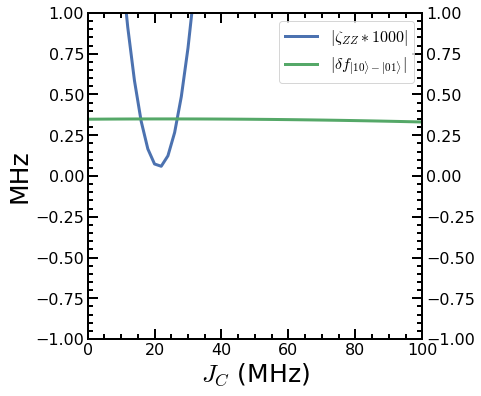

In [93]:
#Calculate ZZ rate:
plt.figure(figsize = [6,6])
zeta_ZZ = energies_coupled_swE[system.level_label('110'),:] - energies_coupled_swE[system.level_label('010'),:] \
- (energies_coupled_swE[system.level_label('100'), :] - energies_coupled_swE[system.level_label('000'), :])
freq_shift = energies_coupled_swE[system.level_label('100'), :] - energies_coupled_swE[system.level_label('010'), :]
freq_shift = freq_shift - freq_anchor
plt.plot(E_int_array*1e3, abs(zeta_ZZ)*1e6, label = r'$|\zeta_{ZZ}*1000|$')
plt.plot(E_int_array*1e3, abs(freq_shift)*1e3, label = r'$|\delta f _{|10\rangle - |01\rangle}|$')

plt.legend()
plt.tick_params(left=True, right=True,labelleft=True, labelright=True)
plt.ylim([-1,1])
plt.ylabel(r'MHz')
plt.xlabel('$J_C$ (MHz)')
plt.xlim([E_int_array[0]*1e3, E_int_array[-1]*1e3])

# Sweep qubit parameters

In [94]:
#Sweep EJ and EL
coupling_type = 'charge'
E_int_direct = 0.02
E_int_res = 0.3
qubit1.phi_ext = np.pi
qubit2.phi_ext = np.pi

EJ_array = np.linspace(2.5,4.5,201)
EL_array = np.linspace(0.4,1,201)
ZZ_rate_mult = np.zeros((len(EJ_array), len(EL_array)))

omega_c = 8
coupl_res = resonator.Cavity(omega=omega_c, nlev=5)

for EJ_idx, E_J2 in enumerate(EJ_array):
    for EL_idx, E_L2 in enumerate(EL_array): 
        qubit1 = fluxonium.Fluxonium(E_J = E_J1, E_C=E_C1, E_L=E_L1, phi_ext=phi_ext1, nlev = nlev_single, nlev_lc = nlev_lc)
        qubit2 = fluxonium.Fluxonium(E_J = E_J2, E_C=E_C2, E_L=E_L2, phi_ext=phi_ext2, nlev = nlev_single, nlev_lc = nlev_lc)
        system = coupobj.CoupledObjects(qubit1, qubit2, coupl_res,
                                    [qubit1, qubit2, E_int_direct, 'charge'],
                                    [coupl_res, qubit1, E_int_res, 'JC-charge'],
                                    [coupl_res, qubit2, E_int_res, 'JC-charge'])
        energies_coupled_mult = system.levels()
        ZZ_rate_mult[EJ_idx, EL_idx] = (energies_coupled_mult[system.level_label('110')] - energies_coupled_mult[system.level_label('010')]) \
        - (energies_coupled_mult[system.level_label('100')] - energies_coupled_mult[system.level_label('000')])

Text(0, 0.5, '$E_{L2}$ (GHz)')

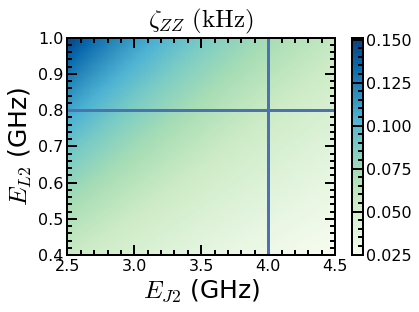

In [95]:
X,Y = np.meshgrid(EJ_array, EL_array)
Z = abs(ZZ_rate_mult).transpose()*1e6
plt.pcolor(X,Y,Z, cmap = 'GnBu')
plt.axvline(x=E_J1)
plt.axhline(y=E_L1)
plt.colorbar()
plt.title(r'$\zeta_{ZZ}~\mathrm{(kHz)}$')
plt.xlabel(r'$E_{J2}$ (GHz)')
plt.ylabel(r'$E_{L2}$ (GHz)')